In [1]:
import os
import torch
import numpy as np
from PIL import Image
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import view_points
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
import matplotlib.pyplot as plt

In [2]:
from core.occlusion_detector.occlusion_detector import occlusion_detector

In [3]:
nusc = NuScenes(version='v1.0-mini', dataroot='/scratch1/ganesang/nuScenes/mini/', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.556 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [4]:
# lidar_token = sample['data']['LIDAR_TOP']
# camera_token = sample['data']['CAM_FRONT']
# lidar = nusc.get('sample_data', lidar_token)
# cam = nusc.get('sample_data', camera_token)
# pcl_path = os.path.join(nusc.dataroot, lidar['filename'])
# pc = LidarPointCloud.from_file(pcl_path)
# im = Image.open(os.path.join(nusc.dataroot, cam['filename']))
# cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
# pc.rotate(R)
# depths = pc.points[2, :]
# coloring = depths
# points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)

# min_dist = 1.0
# mask = np.ones(depths.shape[0], dtype=bool)
# mask = np.logical_and(mask, depths > min_dist)
# mask = np.logical_and(mask, points[0, :] > 1)
# mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
# mask = np.logical_and(mask, points[1, :] > 1)
# mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
# points = points[:, mask]
# coloring = coloring[mask]
# dot_size = 5
# fig, ax = plt.subplots(1, 1, figsize=(9, 16))
# ax.imshow(im)
# ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
# ax.axis('off')

In [5]:
# cs_record = nusc.get('calibrated_sensor', lidar['calibrated_sensor_token'])
# pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
# pc.translate(np.array())

In [6]:
def dense_map(Pts, n, m, grid):
    ng = 2 * grid + 1
    
    mX = np.zeros((m,n)) + np.float("inf")
    mY = np.zeros((m,n)) + np.float("inf")
    mD = np.zeros((m,n))
    mX[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[0] - np.round(Pts[0])
    mY[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[1] - np.round(Pts[1])
    mD[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[2]
    
    KmX = np.zeros((ng, ng, m - ng, n - ng))
    KmY = np.zeros((ng, ng, m - ng, n - ng))
    KmD = np.zeros((ng, ng, m - ng, n - ng))
    
    for i in range(ng):
        for j in range(ng):
            KmX[i,j] = mX[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmY[i,j] = mY[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmD[i,j] = mD[i : (m - ng + i), j : (n - ng + j)]
    S = np.zeros_like(KmD[0,0])
    Y = np.zeros_like(KmD[0,0])
    
    for i in range(ng):
        for j in range(ng):
            s = 1/np.sqrt(KmX[i,j] * KmX[i,j] + KmY[i,j] * KmY[i,j])
            Y = Y + s * KmD[i,j]
            S = S + s
    
    S[S == 0] = 1
    out = np.zeros((m,n))
    out[grid + 1 : -grid, grid + 1 : -grid] = Y/S
    return out

In [7]:
def rotation_matrix(theta_x, theta_y, theta_z):
    theta_x = (np.pi/180)*theta_x
    theta_y = (np.pi/180)*theta_y
    theta_z = (np.pi/180)*theta_z
    Rx = np.array([[1, 0, 0],
               [0, np.cos(theta_x), -np.sin(theta_x)],
               [0, np.sin(theta_x), np.cos(theta_x)]])
    Ry = np.array([[np.cos(theta_y), 0, np.sin(theta_y)],
                [0, 1, 0],
                [-np.sin(theta_y), 0, np.cos(theta_y)]])
    Rz = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                [np.sin(theta_z), np.cos(theta_z), 0],
                [0, 0, 1]])
    
    R = Rx@Ry@Rz

    return R

In [8]:
def geometric_transformation(rotation, translation):
    mat = np.eye(4)
    mat[:3, :3] = rotation
    mat[:3, 3] = translation
    return mat

In [9]:
def render_virtual_plane(sample_token, camera_channel='CAM_FRONT'):
    sample = nusc.get('sample', sample_token)
    lidar_token = sample['data']['LIDAR_TOP']
    camera_token = sample['data'][camera_channel]

    lidar = nusc.get('sample_data', lidar_token)
    cam = nusc.get('sample_data', camera_token)
    pcl_path = os.path.join(nusc.dataroot, lidar['filename'])
    pc = LidarPointCloud.from_file(pcl_path)
    im = Image.open(os.path.join(nusc.dataroot, cam['filename']))

    cam_loc_rot_ang = {'CAM_FRONT': 0,
                   'CAM_FRONT_RIGHT': -55,
                   'CAM_FRONT_LEFT': 55,
                   'CAM_BACK': 180,
                   'CAM_BACK_RIGHT': -110,
                   'CAM_BACK_LEFT': 110}
    R_lidar_to_cam = rotation_matrix(90, 0, 0)
    R_cam_ang = rotation_matrix(0, cam_loc_rot_ang[camera_channel], 0)
    pc.rotate(R_lidar_to_cam)
    pc.rotate(R_cam_ang)
    print(R_lidar_to_cam)
    print(R_cam_ang)
    
    cs_record_lidar = nusc.get('calibrated_sensor', lidar['calibrated_sensor_token'])
    cs_record_cam = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    poserecord_lidar = nusc.get('ego_pose', lidar['ego_pose_token'])
    poserecord_cam = nusc.get('ego_pose', cam['ego_pose_token'])

    cam_intrinsic = np.array(cs_record_cam['camera_intrinsic'])

    lidar_to_veh_rot = Quaternion(cs_record_lidar['rotation']).rotation_matrix
    lidar_to_veh_trans = np.array(cs_record_lidar['translation'])
    lidar_to_veh_mat = geometric_transformation(lidar_to_veh_rot, lidar_to_veh_trans)

    cam_to_veh_rot = Quaternion(cs_record_cam['rotation']).rotation_matrix
    cam_to_veh_trans = np.array(cs_record_cam['translation'])
    cam_to_veh_mat = geometric_transformation(cam_to_veh_rot, cam_to_veh_trans)
    
    veh_to_glb_lidar_rot = Quaternion(poserecord_lidar['rotation']).rotation_matrix
    veh_to_glb_lidar_trans = np.array(poserecord_lidar['translation'])
    veh_to_glb_lidar_mat = geometric_transformation(veh_to_glb_lidar_rot, veh_to_glb_lidar_trans)

    veh_to_glb_cam_rot = Quaternion(poserecord_cam['rotation']).rotation_matrix
    veh_to_glb_cam_trans = np.array(poserecord_cam['translation'])
    veh_to_glb_cam_mat = geometric_transformation(veh_to_glb_cam_rot, veh_to_glb_cam_trans)
    
    #Relative pose from lidar to rgb camera
    relative_pose = lidar_to_veh_mat @ veh_to_glb_lidar_mat @ np.linalg.inv(veh_to_glb_cam_mat) @ np.linalg.inv(cam_to_veh_mat)
    

    # # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
    # # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
    # cs_record = nusc.get('calibrated_sensor', lidar['calibrated_sensor_token'])
    # pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    # pc.translate(np.array(cs_record['translation']))

    # # Second step: transform from ego to the global frame.
    # poserecord = nusc.get('ego_pose', lidar['ego_pose_token'])
    # pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    # pc.translate(np.array(poserecord['translation']))

    # # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
    # poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    # pc.translate(-np.array(poserecord['translation']))
    # pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

    # # Fourth step: transform from ego into the camera.
    # cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    # pc.translate(-np.array(cs_record['translation']))
    # pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)
    # # pc.rotate(R_to_cam)
    # # pc.rotate(R)
    
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    depths = pc.points[2, :]
    coloring = depths
    points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)
    
    min_dist = 1.0
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > min_dist)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
    points = points[:, mask]
    coloring = coloring[mask]

    dot_size = 5
    fig, ax = plt.subplots(1, 1, figsize=(9, 16))
    ax.imshow(im)
    plot = ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
    im_ratio = im.size[1]/im.size[0]
    fig.colorbar(plot, ax=ax, fraction=0.046*im_ratio, pad=0.04)
    ax.axis('off')
    return points, coloring, relative_pose, cam_intrinsic

In [10]:
sample = nusc.sample[15]

[[ 1.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  6.123234e-17 -1.000000e+00]
 [ 0.000000e+00  1.000000e+00  6.123234e-17]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


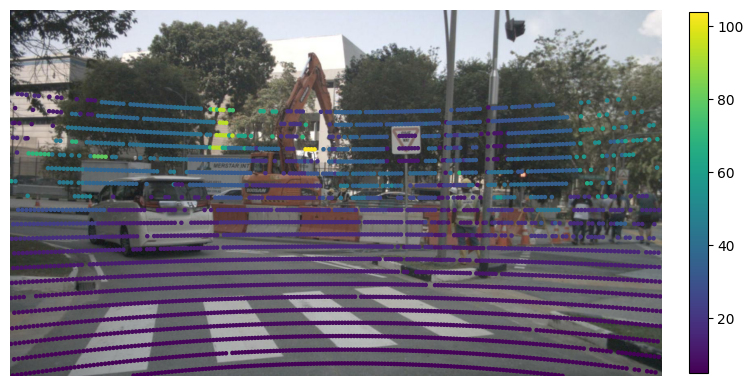

In [11]:
cam = 'CAM_FRONT'
points, depth, relative_pose, cam_intrinsic = render_virtual_plane(sample['token'], camera_channel=cam)
# nusc.render_pointcloud_in_image(sample['token'], pointsensor_channel='LIDAR_TOP', camera_channel=cam)

In [12]:
# from scipy.interpolate import griddata, CloughTocher2DInterpolator
# grid_x, grid_y = np.meshgrid(range(1600),range(900))
# # out = griddata(points[:2,:].T, depth, (grid_x, grid_x), method='nearest')
# interp = LinearNDInterpolator(points[:2,:].T, depth, fill_value=float('inf'))
# new_d = interp(grid_x, grid_y)
# plt.figure(figsize=(10,10))
# plt.imshow(new_d)
# plt.axis('off')

(-0.5, 1599.5, 899.5, -0.5)

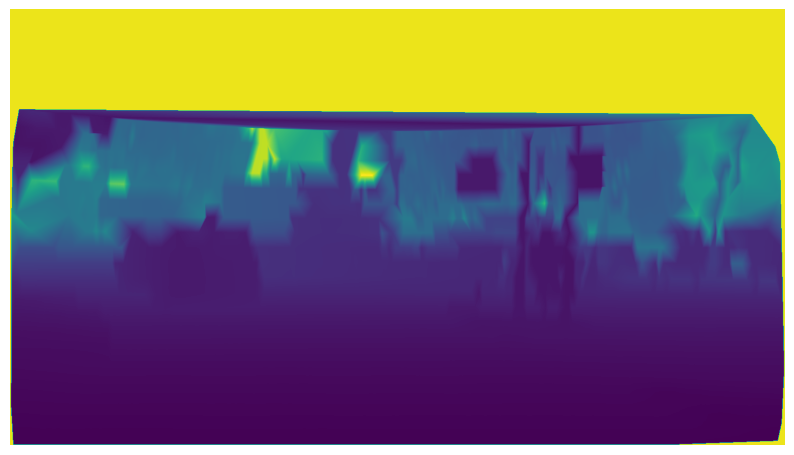

In [13]:
from scipy.interpolate import griddata, LinearNDInterpolator
from scipy.spatial import Delaunay
grid_x, grid_y = np.meshgrid(range(1600),range(900))
tri = Delaunay(points[:2,:].T)
interp_De = LinearNDInterpolator(tri, depth, fill_value=1e2)
intrp_d = interp_De(grid_x, grid_y)
plt.figure(figsize=(10,10))
plt.imshow(intrp_d)
plt.axis('off')

In [14]:
# intrinsic = torch.tensor(cam_intrinsic[None,:,:], dtype=torch.float32)
# intrinsic = torch.concat([intrinsic, torch.zeros(1,3,1)], dim=2).cuda()
intrinsic = torch.eye(4, dtype=torch.float32).cuda()[None,:,:]
intrinsic[:,:3,:3] = torch.tensor(cam_intrinsic, dtype=torch.float32).cuda()
pose = torch.tensor(relative_pose[None,:,:], dtype=torch.float32).cuda()
depthmap = torch.tensor(intrp_d[None,None,:,:], dtype=torch.float32).cuda()
occ_map = occlusion_detector.apply(intrinsic, pose, depthmap, 99999999)

tensor(1440000, device='cuda:0')


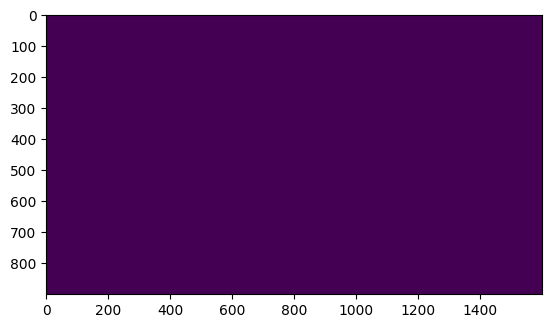

In [15]:
print(occ_map.sum())
plt.imshow(occ_map.to('cpu')[0,0])

In [37]:
bz, _, h, w = depthmap.shape #Lidar Plane

minsr_dist = 1
pose_pr = torch.clone(pose)
pose_pr[:, 0:3, 3] = 0

cam_org_3d = torch.zeros([bz, 4, 1], device=depthmap.device, dtype=torch.float32)
cam_org_3d[:, 3, :] = 1
epp1 = intrinsic @ torch.inverse(pose) @ cam_org_3d  # Epipole on frame 1, projection of camera 2
epp1[:, 0, 0] = epp1[:, 0, 0] / epp1[:, 2, 0]
epp1[:, 1, 0] = epp1[:, 1, 0] / epp1[:, 2, 0]
epp1 = epp1[:, 0:2, 0]
epp2 = intrinsic @ pose @ cam_org_3d  # Epipole on frame 2, projection of camera 1
epp2[:, 0, 0] = epp2[:, 0, 0] / epp2[:, 2, 0]
epp2[:, 1, 0] = epp2[:, 1, 0] / epp2[:, 2, 0]
epp2 = epp2[:, 0:2, 0]

xx, yy = np.meshgrid(range(w), range(h), indexing='xy')
xx = torch.from_numpy(xx).view([1, h, w, 1, 1]).expand([bz, -1, -1, -1, -1]).float().cuda(depthmap.device)
yy = torch.from_numpy(yy).view([1, h, w, 1, 1]).expand([bz, -1, -1, -1, -1]).float().cuda(depthmap.device)
ones = torch.ones_like(xx)
depthmap_rs = depthmap.squeeze(1).unsqueeze(-1).unsqueeze(-1)
pts3d_v1_batch = torch.cat([xx * depthmap_rs, yy * depthmap_rs, depthmap_rs, ones], axis=3)#LidarPlane
pts2d_v1_batch = torch.cat([xx, yy], axis=3).squeeze(-1)

pM1 = intrinsic @ torch.inverse(pose) @ torch.inverse(intrinsic)
pM1 = pM1.view([bz, 1, 1, 4, 4]).expand([-1, h, w, -1, -1])
pts3d_v2_batch = pM1 @ pts3d_v1_batch#Lidar to RGB
pts2d_v2_batch = torch.clone(pts3d_v2_batch)
pts2d_v2_batch[:, :, :, 0, 0] = pts2d_v2_batch[:, :, :, 0, 0] / pts2d_v2_batch[:, :, :, 2, 0]
pts2d_v2_batch[:, :, :, 1, 0] = pts2d_v2_batch[:, :, :, 1, 0] / pts2d_v2_batch[:, :, :, 2, 0]
pts2d_v2_batch = pts2d_v2_batch[:, :, :, 0:2, 0]
out_range_selecor = (pts3d_v2_batch[:, :, :, 2, 0] >= 0) * (pts2d_v2_batch[:, :, :, 0] >= 0) * (pts2d_v2_batch[:, :, :, 0] <= w - 1) * (pts2d_v2_batch[:, :, :, 1] >= 0) * (pts2d_v2_batch[:, :, :, 1] <= h - 1)
out_range_selecor = (out_range_selecor == 0)
occ_selector = torch.clone(out_range_selecor).unsqueeze(1)

# pM2 = intrinsic @ torch.inverse(pose_pr) @ torch.inverse(intrinsic) @ intrinsic @ pose @ torch.inverse(intrinsic)
# pM2 = pM2.view([bz, 1, 1, 4, 4]).expand([-1, h, w, -1, -1])
# pts2dsrch_v1_batch = pM2 @ pts3d_v1_batch#RGB to Lidar
# pts2dsrch_v1_batch[:, :, :, 0, 0] = pts2dsrch_v1_batch[:, :, :, 0, 0] / pts2dsrch_v1_batch[:, :, :, 2, 0]
# pts2dsrch_v1_batch[:, :, :, 1, 0] = pts2dsrch_v1_batch[:, :, :, 1, 0] / pts2dsrch_v1_batch[:, :, :, 2, 0]
# pts2dsrch_v1_batch = pts2dsrch_v1_batch[:, :, :, 0:2, 0]

# srh_distance = torch.sqrt(torch.sum((pts2dsrch_v1_batch - pts2d_v1_batch) ** 2 + 1e-10, axis=3))

In [36]:
w,h

(1600, 900)

In [39]:
((pts2d_v2_batch[:, :, :, 1] >= 0) * (pts2d_v2_batch[:, :, :, 1] <= h - 1)).sum()
occ_selector.sum()

tensor(1440000, device='cuda:0')

In [18]:
pts2dsrch_v1_batch.shape

torch.Size([1, 900, 1600, 4, 1])

In [20]:
pM2

tensor([[[[[ 1.0000e+00, -7.5305e-10,  1.2207e-04,  4.3905e+02],
           [ 3.0122e-09,  1.0000e+00, -1.5259e-04, -9.8124e+03],
           [ 5.8832e-12, -8.5031e-13,  1.0000e+00,  5.9729e-01],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

          [[ 1.0000e+00, -7.5305e-10,  1.2207e-04,  4.3905e+02],
           [ 3.0122e-09,  1.0000e+00, -1.5259e-04, -9.8124e+03],
           [ 5.8832e-12, -8.5031e-13,  1.0000e+00,  5.9729e-01],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

          [[ 1.0000e+00, -7.5305e-10,  1.2207e-04,  4.3905e+02],
           [ 3.0122e-09,  1.0000e+00, -1.5259e-04, -9.8124e+03],
           [ 5.8832e-12, -8.5031e-13,  1.0000e+00,  5.9729e-01],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

          ...,

          [[ 1.0000e+00, -7.5305e-10,  1.2207e-04,  4.3905e+02],
           [ 3.0122e-09,  1.0000e+00, -1.5259e-04, -9.8124e+03],
           [ 5.8832e-12, -8.5031e-13,  1.0000e+00,  5.9729e-01],
   